<font color='#E27271'>

# *Unveiling Complex Interconnections Among Companies through Learned Embeddings*</font>

-----------------------
<font color='#E27271'>

Ethan Moody, Eugene Oon, and Sam Shinde</font>

<font color='#E27271'>

August 2023</font>

-----------------------
<font color='#00AED3'>

# **Model: RoBERTa** </font>
-----------------------

RoBERTa, which stands for "A Robustly Optimized BERT Pretraining Approach" is a highly influential natural language processing (NLP) model developed by Facebook AI in 2019. It is built upon the foundation of BERT (Bidirectional Encoder Representations from Transformers) but incorporates several key modifications and optimizations to enhance its performance. RoBERTa is an advanced variant of BERT which addresses some of its limitations by refining the pretraining process.

We will use [RoBERTa](https://huggingface.co/docs/transformers/model_doc/roberta) to encode summarized Item 1 ("Business") of SEC 10-K reports using XLNet summarization for companies listed on NYSE and NASDAQ. The goal is to predict the GICS sector mutliclass classification for these companies. For fine-tuning RoBERTa, we unfroze all layers during training and validation, added two additional hidden layers of 256 neurons, and incorporated a neural dropout rate of 0.20 in between each hidden layer to help prevent overfitting.

## [1] Installs, Imports and Setups

### [1.1] Complete Initial Installs

In [ ]:
# Installs
!pip install transformers --quiet
!python -m spacy download en_core_web_lg --quiet
!pip install sentencepiece --quiet

2023-08-07 03:41:11.583952: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-07 03:41:12.588149: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-08-07 03:41:13.877913: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-07 03:41:13.878415: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returnin

### [1.2] Import Packages

In [ ]:
# Imports General Packages
import os, sys
import pandas as pd
import json
from datetime import date
import re
from datetime import datetime

#
import jax
from jax import numpy as jnp
import itertools

# Import Transformers
from transformers import BertTokenizer, TFBertModel, BertConfig, TFRobertaModel
import tensorflow as tf
from sklearn.metrics import confusion_matrix

# spacy
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_lg')
#run_opts = tf.RunOptions(report_tensor_allocations_upon_oom = True)

# Setup
# path = '/content/gdrive/My Drive/Working'
path = '/content/gdrive/My Drive/project'

### [1.3] Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## [2] Helper Functions

### [2.1] Clean Input Text

In [ ]:
def clean(rawtext):
  """Function to remove unwanted text which might impact model performance, such as -
      Remove Special Characters
      Remove Consecutive Whitespace
      Remove new line characters
      Remove Table Content
      Remove all characters except lowercase or uppercase alphabetic character
      (a-z, A-Z) or a whitespace character (\s) or dot (.)
  """

  # Remove specific (non-breaking space) character sequence
  rawtext = rawtext.replace('\\xa0','')

  # Remove New Line (escape the backslash)
  rawtext = rawtext.replace('\\n','')

  # pattern that matches one or more consecutive whitespace characters
  rawtext = re.sub('\s\s+',' ',rawtext)

  # Replace new line with Space
  rawtext = re.sub('\n',' ',rawtext)

  # Replace Table Content
  rawtext = re.sub("(?is)<table[^>]*>(.*?)<\/table>", "", rawtext)

  # pattern that matches any character that is not a lowercase or uppercase alphabetic character (a-z, A-Z) or a whitespace character (\s)
  rawtext = re.sub(r'[^A-Za-z .]+', '', rawtext)
  # rawtext = re.sub(r'[^A-Za-z0-9 .]+', '', rawtext)
  # rawtext = re.sub('[^a-zA-Z\s]','',rawtext)

  # pattern that matches one or more consecutive digits
  # rawtext = re.sub(r'\d+', '', rawtext)

  rawtext = re.sub('I tem','',rawtext)
  rawtext = re.sub('TABLEEND','',rawtext)
  rawtext = re.sub('TABLESTART','',rawtext)

  # matches one or more consecutive spaces
  rawtext = re.sub(' +', ' ', rawtext)

  return rawtext

### [2.2] Number of GPUs

In [ ]:
def num_gpus():
    """Get the number of available GPUs."""
    try:
        return jax.device_count('gpu')
    except:
        return 0  # No GPU backend found

num_gpus()

1

### [2.3] Replace NER

In [ ]:
def replace_ner(mytxt):
    clean_text = mytxt
    doc = nlp(mytxt)
    for ent in reversed(doc.ents):
      if ent.label_ == 'ORG':
        clean_text = clean_text[:ent.start_char] +ent.label_ + clean_text[ent.end_char:]
    return clean_text

## [3] Modeling Data Preparation

### [3.1] Load and Clean Data

In [ ]:
# Load json file
data_df = pd.read_json(path + '/data/10K/xlnet_nsp_summary_final.json')
data_df.head()
data_df = data_df[['ticker','name','business','sector']]

test_df = pd.read_json(path + '/data/10K/xlnet_sp_summary_final.json')
test_df.head()
test_df = test_df[['ticker','name','business','sector']]

### [3.2] Check for Data Imbalance

In [ ]:
# Check for data imbalance
data_df.sector.value_counts()

Health Care               954
Financials                636
Industrials               472
Information Technology    438
Consumer Discretionary    398
Energy                    170
Real Estate               167
Communication Services    160
Consumer Staples          123
Materials                 120
Utilities                  44
Name: sector, dtype: int64

### [3.3] Combine Consumer Class

In [ ]:
# Update Sector values to only 10 sector (Merge Consumer Discretionary and Consumer Staples)

# Training Dataset
data_df['sector'] = data_df['sector'].replace('Consumer Discretionary','Consumer Discretionary and Staples')
data_df['sector'] = data_df['sector'].replace('Consumer Staples','Consumer Discretionary and Staples')
data_df.sector.value_counts()

Health Care                           954
Financials                            636
Consumer Discretionary and Staples    521
Industrials                           472
Information Technology                438
Energy                                170
Real Estate                           167
Communication Services                160
Materials                             120
Utilities                              44
Name: sector, dtype: int64

In [ ]:
# Test Dataset
test_df['sector'] = test_df['sector'].replace('Consumer Discretionary','Consumer Discretionary and Staples')
test_df['sector'] = test_df['sector'].replace('Consumer Staples','Consumer Discretionary and Staples')
test_df.sector.value_counts()

Consumer Discretionary and Staples    90
Industrials                           75
Financials                            72
Health Care                           65
Information Technology                65
Real Estate                           31
Utilities                             30
Materials                             29
Energy                                23
Communication Services                20
Name: sector, dtype: int64

### [3.4] Encoding Labels

In [ ]:
# Encoding Labels
labels = sorted(data_df.sector.dropna().unique())

label_dict = {}
for index, label in enumerate(labels):
    label_dict[label] = index
label_dict

{'Communication Services': 0,
 'Consumer Discretionary and Staples': 1,
 'Energy': 2,
 'Financials': 3,
 'Health Care': 4,
 'Industrials': 5,
 'Information Technology': 6,
 'Materials': 7,
 'Real Estate': 8,
 'Utilities': 9}

In [ ]:
# List labels
list(label_dict.keys())

['Communication Services',
 'Consumer Discretionary and Staples',
 'Energy',
 'Financials',
 'Health Care',
 'Industrials',
 'Information Technology',
 'Materials',
 'Real Estate',
 'Utilities']

In [ ]:
# Apply label encoding to Training data
data_df['label'] = data_df.sector.replace(label_dict)
data_df.head()

,ticker,name,business,sector,label
0,MBLY,Mobileye Global Inc,References to Moovit refer to GG Acquisition L...,Consumer Discretionary and Staples,1
1,RIVN,Rivian Automotive Inc,Business Overview Rivian exists to create prod...,Consumer Discretionary and Staples,1
2,LCID,Lucid Group Inc,OVERVIEW Mission Lucids mission is to inspire ...,Consumer Discretionary and Staples,1
3,LEA,Lear Corp,ITEM BUSINESS In this Annual Report on Form K ...,Consumer Discretionary and Staples,1
4,ALV,Autoliv Inc,Business General Autoliv Inc. Autoliv the Comp...,Consumer Discretionary and Staples,1


In [ ]:
# Apply label encoding to Test data
test_df['label'] = test_df.sector.replace(label_dict)
test_df.head()

,ticker,name,business,sector,label
0,TSLA,Tesla Inc,BUSINESS Overview We design develop manufactur...,Consumer Discretionary and Staples,1
1,F,Ford Motor Co,Ford Motor Company was incorporated in Delawar...,Consumer Discretionary and Staples,1
2,GM,General Motors Co,Business General Motors Company sometimes refe...,Consumer Discretionary and Staples,1
3,APTV,Aptiv PLC,BUSINESS Aptiv the Company we us and our refer...,Consumer Discretionary and Staples,1
4,BWA,BorgWarner Inc.,Business BorgWarner Inc. together with its Con...,Consumer Discretionary and Staples,1


### [3.5] Drop NAs

In [ ]:
# NaNs in Train data
data_df.isna().sum()

ticker      0
name        0
business    0
sector      0
label       0
dtype: int64

In [ ]:
# Drop NA from Training Data (if any)
print(f'Shape before: {data_df.shape}')
data_df.dropna(inplace=True)
data_df.reset_index(drop=True, inplace=True)
print(f'Shape after: {data_df.shape}')

Shape before: (3682, 5)
Shape after: (3682, 5)


In [ ]:
# Get length of the business
data_df['bus_len']=data_df['business'].apply(lambda x: len(x))
data_df.head()
test_df['bus_len']=test_df['business'].apply(lambda x: len(x))
test_df.head()

,ticker,name,business,sector,label,bus_len
0,TSLA,Tesla Inc,BUSINESS Overview We design develop manufactur...,Consumer Discretionary and Staples,1,4271
1,F,Ford Motor Co,Ford Motor Company was incorporated in Delawar...,Consumer Discretionary and Staples,1,3470
2,GM,General Motors Co,Business General Motors Company sometimes refe...,Consumer Discretionary and Staples,1,4860
3,APTV,Aptiv PLC,BUSINESS Aptiv the Company we us and our refer...,Consumer Discretionary and Staples,1,5174
4,BWA,BorgWarner Inc.,Business BorgWarner Inc. together with its Con...,Consumer Discretionary and Staples,1,3963


In [ ]:
data_df.nsmallest(10, "bus_len", keep="all")[["ticker","name","bus_len"]]

,ticker,name,bus_len
3109,TCI,Transcontinental Realty Investors Inc,2439
3096,RDFN,Redfin Corp,2592
3108,ARL,"American Realty Investors, Inc.",2660
1939,GEG,Great Elm Group Inc,2679
1443,SQFT,Presidio Property Trust Inc,2714
3634,PATI,Patriot Transportation Holding Inc,2731
614,PPIH,Perma-Pipe International Holdings Inc,2743
1531,RC,Ready Capital Corp,2785
1361,OFC,Corporate Office Properties Trust,2809
198,FFIC,Flushing Financial Corp,2819


In [ ]:
test_df.nsmallest(10, "bus_len", keep="all")[["ticker","name","bus_len"]]

,ticker,name,bus_len
8,C,Citigroup Inc,2899
156,TRGP,Targa Resources Corp,3046
388,TXN,Texas Instruments Inc,3049
135,DLTR,Dollar Tree Inc,3077
130,COST,Costco Wholesale Corporation,3085
475,XEL,Xcel Energy Inc,3173
269,STE,Steris PLC,3190
87,ROST,Ross Stores Inc,3192
40,ROK,Rockwell Automation Inc,3200
27,ETN,Eaton Corporation PLC,3222


In [ ]:
# Drop business length ZERO
data_df = data_df[data_df['bus_len']!=0]
data_df.reset_index(drop=True, inplace=True)
data_df.shape

(3682, 6)

In [ ]:
# Drop NA from Test Data
print(f'Shape before: {test_df.shape}')
test_df.dropna(inplace=True)
test_df.reset_index(drop=True, inplace=True)
print(f'Shape after: {test_df.shape}')

Shape before: (500, 6)
Shape after: (500, 6)


### [3.6] Clean Business Description

In [ ]:
# Clean business description on Training dataset
data_df['business_clean']= data_df['business'].apply(lambda x: clean(x))

In [ ]:
data_df.head()

,ticker,name,business,sector,label,bus_len,business_clean
0,MBLY,Mobileye Global Inc,References to Moovit refer to GG Acquisition L...,Consumer Discretionary and Staples,1,5400,References to Moovit refer to GG Acquisition L...
1,RIVN,Rivian Automotive Inc,Business Overview Rivian exists to create prod...,Consumer Discretionary and Staples,1,3982,Business Overview Rivian exists to create prod...
2,LCID,Lucid Group Inc,OVERVIEW Mission Lucids mission is to inspire ...,Consumer Discretionary and Staples,1,4282,OVERVIEW Mission Lucids mission is to inspire ...
3,LEA,Lear Corp,ITEM BUSINESS In this Annual Report on Form K ...,Consumer Discretionary and Staples,1,4384,ITEM BUSINESS In this Annual Report on Form K ...
4,ALV,Autoliv Inc,Business General Autoliv Inc. Autoliv the Comp...,Consumer Discretionary and Staples,1,4371,Business General Autoliv Inc. Autoliv the Comp...


In [ ]:
# Clean business description on Test dataset
test_df['business_clean']= test_df['business'].apply(lambda x: clean(x))
test_df.head()

,ticker,name,business,sector,label,bus_len,business_clean
0,TSLA,Tesla Inc,BUSINESS Overview We design develop manufactur...,Consumer Discretionary and Staples,1,4271,BUSINESS Overview We design develop manufactur...
1,F,Ford Motor Co,Ford Motor Company was incorporated in Delawar...,Consumer Discretionary and Staples,1,3470,Ford Motor Company was incorporated in Delawar...
2,GM,General Motors Co,Business General Motors Company sometimes refe...,Consumer Discretionary and Staples,1,4860,Business General Motors Company sometimes refe...
3,APTV,Aptiv PLC,BUSINESS Aptiv the Company we us and our refer...,Consumer Discretionary and Staples,1,5174,BUSINESS Aptiv the Company we us and our refer...
4,BWA,BorgWarner Inc.,Business BorgWarner Inc. together with its Con...,Consumer Discretionary and Staples,1,3963,Business BorgWarner Inc. together with its Con...


### [3.7] Train Validation Split

In [ ]:
# Split and relabel final Non-S&P 500 set into TRAINING and VALIDATION subsets
# Note: 15% Non-S&P 500 volume allocated from TRAINING to VALIDATION
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(data_df.index.values,
                                                  data_df.label.values,
                                                  test_size=0.15,
                                                  random_state=42,
                                                  stratify=data_df.label.values)

data_df['data_type'] = ['not_set']*data_df.shape[0]

data_df.loc[X_train, 'data_type'] = 'train'
data_df.loc[X_val, 'data_type'] = 'val'

data_df.groupby(['sector', 'label', 'data_type']).count()

ticker  name  business  \
sector                             label data_type                           
Communication Services             0     train         136   136       136   
                                         val            24    24        24   
Consumer Discretionary and Staples 1     train         443   443       443   
                                         val            78    78        78   
Energy                             2     train         144   144       144   
                                         val            26    26        26   
Financials                         3     train         541   541       541   
                                         val            95    95        95   
Health Care                        4     train         811   811       811   
                                         val           143   143       143   
Industrials                        5     train         401   401       401   
                                         val            71    71        71   
Information Technology             6     train         372   372       372   
                                         val            66    66        66   
Materials                          7     train         102   102       102   
                                         val            18    18        18   
Real Estate                        8     train         142   142       142   
                                         val            25    25        25   
Utilities                          9     train          37    37        37   
                                         val             7     7         7   

                                                    bus_len  business_clean  
sector                             label data_type                           
Communication Services             0     train          136             136  
                                         val             24              24  
Consumer Discretionary and Staples 1     train          443             443  
                                         val             78              78  
Energy                             2     train          144             144  
                                         val             26              26  
Financials                         3     train          541             541  
                                         val             95              95  
Health Care                        4     train          811             811  
                                         val            143             143  
Industrials                        5     train          401             401  
                                         val             71              71  
Information Technology             6     train          372             372  
                                         val             66              66  
Materials                          7     train          102             102  
                                         val             18              18  
Real Estate                        8     train          142             142  
                                         val             25              25  
Utilities                          9     train           37              37  
                                         val              7               7

In [ ]:
# Display sample of labels from TRAINING and VALIDATION sets
import numpy as np
train_labels = np.asarray(y_train, dtype = 'int')
valid_labels = np.asarray(y_val, dtype = 'int')
print(f'Train Labels[:2]: {train_labels[:2]}')
print(f'Valid Labels[:2]: {valid_labels[:2]}')

Train Labels[:2]: [3 6]
Valid Labels[:2]: [4 3]


In [ ]:
# Prepare TRAINING, VALIDATION, and TESTING set records for examination
train_texts = list(data_df['business_clean'].loc[data_df.index[X_train]].values)
valid_texts = list(data_df['business_clean'].loc[data_df.index[X_val]].values)

In [ ]:
y_test = list(test_df['label'].values)
test_labels = np.asarray(y_test, dtype = 'int')
print(f'Test Labels[:2]: {test_labels[:2]}')

Test Labels[:2]: [1 1]


In [ ]:
# Examine sample TEST set records
test_texts = list(test_df['business_clean'].values)
test_texts[:1]

['BUSINESS Overview We design develop manufacture sell and lease highperformance fully electric vehicles and energy generation and storage systems and offer services related to our products. We plan to continue leveraging developments in our proprietary Full SelfDriving FSD battery cell and other technologies. We have designed our proprietary powertrain systems to be adaptable efficient reliable and costeffective while withstanding the rigors of an automotive environment. By taking a modular approach to the design of battery systems we can optimize manufacturing capacity of our energy storage products. We designed both products to integrate with Powerwall. Energy Generation and Storage Our expertise in electrical mechanical civil and software engineering allows us to design engineer manufacture and install energy generating and storage products and components including at the residential through utility scale. However sales of vehicles in the automobile industry tend to be cyclical in 

## [4] Building and Training Model

### [4.1] Create Model Function

In [ ]:
# Create function for RoBERTa fine-tuning - multiclass classification
def create_rbert_multiclass_model(checkpoint,
                                 num_classes = 10,
                                 hidden_size = 256,
                                 dropout=0.2,
                                 learning_rate=0.00001):
    """
    Build a simple classification model with BERT. Use the Pooler Output for classification purposes.
    """
    rbert_model = TFRobertaModel.from_pretrained(checkpoint)

    ### YOUR CODE HERE

      # Fully trainable BERT model
    rbert_model.trainable = True

    # Input
    input_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='input_ids_layer')
    # token_type_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='token_type_ids_layer')
    attention_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int64, name='attention_mask_layer')

    rbert_inputs = {'input_ids': input_ids,
                   # 'token_type_ids': token_type_ids,
                   'attention_mask': attention_mask}

    # BERT Output
    rbert_out = rbert_model(rbert_inputs)

    # Pooler Output Vector
    pooler_token = rbert_out[1]

    # Hidden Layer
    hidden = tf.keras.layers.Dense(hidden_size, activation='relu', name='hidden_layer_1')(pooler_token)

    # Dropout
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Hidden Layer
    hidden = tf.keras.layers.Dense(int(hidden_size/2), activation='relu', name='hidden_layer_2')(hidden)

    # Dropout
    hidden = tf.keras.layers.Dropout(dropout)(hidden)

    # Classification
    classification = tf.keras.layers.Dense(num_classes, activation='softmax',name='classification_layer')(hidden)

    # Output Layer
    # classification_model = tf.keras.Model(inputs=[input_ids, token_type_ids, attention_mask], outputs=[classification])
    classification_model = tf.keras.Model(inputs=[input_ids, attention_mask], outputs=[classification, hidden])

    # Compile
    classification_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                                 #loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                                 loss=['sparse_categorical_crossentropy', None],
                                 #loss='binary_crossentropy',
                                 metrics=['accuracy', None])
    ### END YOUR CODE

    return classification_model

### [4.2] Confusion Matrix Function

In [ ]:
# Function for Confusion Matrix
def make_confusion_matrix(
    y_true,
    y_pred,
    classes=None,
    figsize=(10, 10),
    text_size=40,
    norm=False,
    savefig=False,
):
    """
    Args:
      y_true: Array of truth labels (must be same shape as y_pred).
      y_pred: Array of predicted labels (must be same shape as y_true).
      classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
      figsize: Size of output figure (default=(10, 10)).
      text_size: Size of output figure text (default=15).
      norm: normalize values or not (default=False).
      savefig: save confusion matrix to file (default=False).

    Returns:
      A labelled confusion matrix plot comparing y_true and y_pred.
    Example usage:
      make_confusion_matrix(y_true=test_labels, # ground truth test labels
                            y_pred=y_preds, # predicted labels
                            classes=class_names, # array of class label names
                            figsize=(15, 15),
                            text_size=10)
    """
    # Create the confustion matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]  # normalize it
    n_classes = cm.shape[0]  # find the number of classes we're dealing with

    # Plot the figure and make it pretty
    fig, ax = plt.subplots(figsize=figsize)
    cax = ax.matshow(
        cm, cmap=plt.cm.Blues
    )  # colors will represent how 'correct' a class is, darker == better
    fig.colorbar(cax)

    # Are there a list of classes?
    if classes:
        labels = classes
    else:
        labels = np.arange(cm.shape[0])

    # Label the axes
    ax.set(
        title="Confusion Matrix",
        xlabel="Predicted label",
        ylabel="True label",
        xticks=np.arange(n_classes),  # create enough axis slots for each class
        yticks=np.arange(n_classes),
    )

    # Set x-labels
    ax.set_xticklabels(labels, rotation=90, fontsize=10)
    ax.set_yticklabels(labels, rotation=0, fontsize=10)

    # Set Title
    plt.title("Confusion Matrix", fontsize=18)

    # Make x-axis labels appear on bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()
    ax.xaxis.label.set_fontsize(10)
    ax.yaxis.label.set_fontsize(10)

    # Set the threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.0
    # threshold = (cm_norm.max() + cm_norm.min()) / 2.0

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if norm:
            plt.text(
                j,
                i,
                f"{cm[i, j]} \n ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )
        else:
            plt.text(
                j,
                i,
                f"{cm[i, j]}",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=text_size,
            )

    # Save the figure to the current working directory
    if savefig:
        fig.savefig("confusion_matrix.png")

### [4.3] Plot Loss Curves

In [ ]:
# Function to Plot Loss Curves
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """
  loss = history.history['classification_layer_loss']
  val_loss = history.history['val_classification_layer_loss']

  accuracy = history.history['classification_layer_accuracy']
  val_accuracy = history.history['val_classification_layer_accuracy']

  epochs = range(len(history.history['classification_layer_loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()

### [4.4] Build Model

In [ ]:
# Tokenizer
from transformers import RobertaTokenizer, TFRobertaModel, TFAutoModelForSequenceClassification

roberta_tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

### [4.5] Tokenize Training, Validation and Test Data

In [ ]:
stime = datetime.now()

# tokenize the dataset, truncate when passed `max_length`,
# and pad with 0's when less than `max_length` and return a tf Tensor
max_length = 512
train_encodings = roberta_tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
valid_encodings = roberta_tokenizer(valid_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
test_encodings = roberta_tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='tf')
stime = datetime.now()
etime = datetime.now()
print(f'Total time taken is: {((etime-stime).total_seconds())/60}')

Total time taken is: 0.3553447


### [4.6] Apply Weights (to correct Imbalance)

In [ ]:
# Handling class imbalance
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                 classes=np.unique(data_df.label),
                                                 y=train_labels)

print(class_weights)

weights={}
for index, weight in enumerate(class_weights) :
  weights[index]=weight

print(weights)

[2.30073529 0.70632054 2.17291667 0.57837338 0.38581998 0.78029925
 0.84112903 3.06764706 2.20352113 8.45675676]
{0: 2.300735294117647, 1: 0.7063205417607223, 2: 2.1729166666666666, 3: 0.5783733826247689, 4: 0.3858199753390876, 5: 0.7802992518703242, 6: 0.8411290322580646, 7: 3.0676470588235296, 8: 2.203521126760563, 9: 8.456756756756757}


### [4.7] Create Model

In [ ]:
# Create Model
pooler_rbert_model_wt = create_rbert_multiclass_model(checkpoint='roberta-base', num_classes=10)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaModel: ['lm_head.layer_norm.weight', 'roberta.embeddings.position_ids', 'lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing TFRobertaModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFRobertaModel were not initialized from the PyTorch model and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and infe

### [4.8] Fit Model

In [ ]:
# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_classification_layer_accuracy',
                                     patience=4,
                                     min_delta=0.02,
                                     restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_classification_layer_accuracy',
                                         factor=1e-6,
                                         patience=2,
                                         verbose=0,
                                         mode='auto',
                                         min_delta=0.001,
                                         cooldown=0,
                                         min_lr=1e-6)
]

In [ ]:
#It takes 10 to 14 minutes to complete an epoch when using a GPU
stime = datetime.now()
pooler_rbert_model_wt_history = pooler_rbert_model_wt.fit(
                                                  [train_encodings.input_ids,
                                                  train_encodings.attention_mask],
                                                  train_labels,
                                                  validation_data=(
                                                      [valid_encodings.input_ids,
                                                      valid_encodings.attention_mask],
                                                  valid_labels),
                                                  shuffle=True,
                                                  batch_size=8,
                                                  epochs=15,
                                                  class_weight=weights,
                                                          callbacks=callbacks)

Epoch 1/15
392/392 [==============================] - 475s 1s/step - loss: 1.3462 - classification_layer_loss: 1.3462 - classification_layer_accuracy: 0.5980 - dropout_38_accuracy: 0.0058 - val_loss: 0.6759 - val_classification_layer_loss: 0.6759 - val_classification_layer_accuracy: 0.8156 - val_dropout_38_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 2/15
392/392 [==============================] - 433s 1s/step - loss: 0.5735 - classification_layer_loss: 0.5735 - classification_layer_accuracy: 0.8469 - dropout_38_accuracy: 9.5877e-04 - val_loss: 0.4680 - val_classification_layer_loss: 0.4680 - val_classification_layer_accuracy: 0.8698 - val_dropout_38_accuracy: 0.0000e+00 - lr: 1.0000e-05
Epoch 3/15
392/392 [==============================] - 433s 1s/step - loss: 0.3833 - classification_layer_loss: 0.3833 - classification_layer_accuracy: 0.8987 - dropout_38_accuracy: 0.0013 - val_loss: 0.4146 - val_classification_layer_loss: 0.4146 - val_classification_layer_accuracy: 0.8770 - val_dropout

In [ ]:
# pooler_rbert_model.save_pretrained('/content/gdrive/My Drive/project/models/rbert_bal_ft/')
pooler_rbert_model_wt.save('/content/gdrive/My Drive/project/models/rbert_weight_ft/')

In [ ]:
etime = datetime.now()
print(f'Total time taken is: {((etime-stime).total_seconds())/60}')

Total time taken is: 66.6573432


### [4.9] Loss and Accuracy Curves

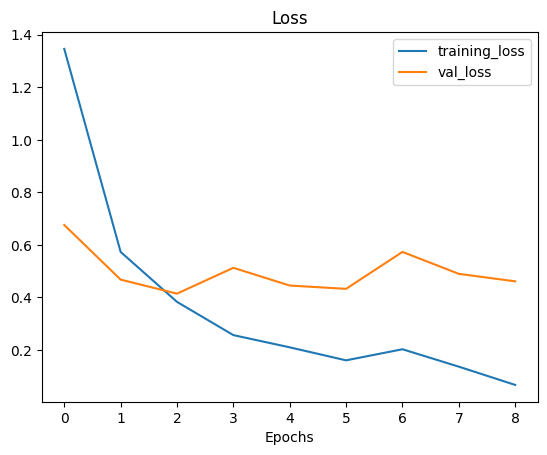

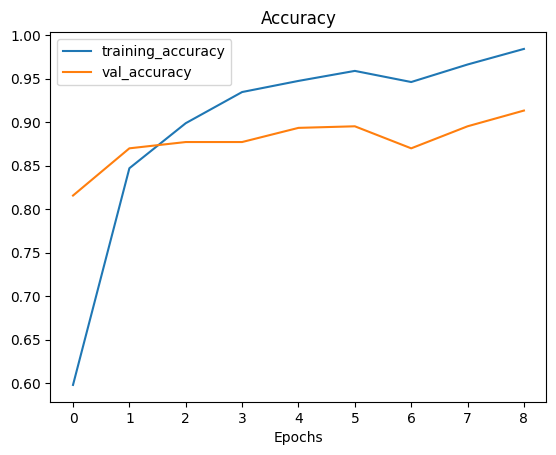

In [ ]:
# Plot history of model results by epoch
import matplotlib.pyplot as plt

plot_loss_curves(pooler_rbert_model_wt_history)

### [4.10] Predict

In [ ]:
# Generate class predictions on TESTING set
pred = pooler_rbert_model_wt.predict([test_encodings.input_ids,
                                      test_encodings.attention_mask])
pred_output = tf.argmax(pred[0], axis=-1)
pred_output

16/16 [==============================] - 23s 1s/step


<tf.Tensor: shape=(500,), dtype=int64, numpy=
array([1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 5, 6, 5,
       5, 1, 5, 5, 5, 5, 4, 5, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 6, 5, 5,
       5, 5, 5, 5, 5, 5, 3, 3, 1, 3, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 8, 6, 8, 1, 1, 1, 1, 1, 1,
       5, 1, 1, 1, 1, 1, 8, 8, 8, 1, 1, 1, 1, 1, 8, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 8, 8, 6, 8, 8, 8, 8, 8, 6, 8, 8, 8, 8, 5, 8, 8,
       8, 8, 8, 6, 8, 8, 8, 8, 8, 8, 8, 8, 8, 3, 3, 3, 3, 5, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 6,
       3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7,
       1, 1, 1, 4, 4, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 1, 1, 1, 7,
     

### [4.11] Classification Report

In [ ]:
# Generate multiclass classification report based on TESTING set predictions
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred_output.numpy(), target_names=labels))

                                    precision    recall  f1-score   support

            Communication Services       0.90      0.95      0.93        20
Consumer Discretionary and Staples       0.96      0.86      0.91        90
                            Energy       0.92      1.00      0.96        23
                        Financials       0.93      0.96      0.95        72
                       Health Care       0.95      0.95      0.95        65
                       Industrials       0.87      0.87      0.87        75
            Information Technology       0.86      0.92      0.89        65
                         Materials       0.86      0.86      0.86        29
                       Real Estate       0.81      0.84      0.83        31
                         Utilities       1.00      0.97      0.98        30

                          accuracy                           0.91       500
                         macro avg       0.91      0.92      0.91       500
          

### [4.12] Confusion Matrix

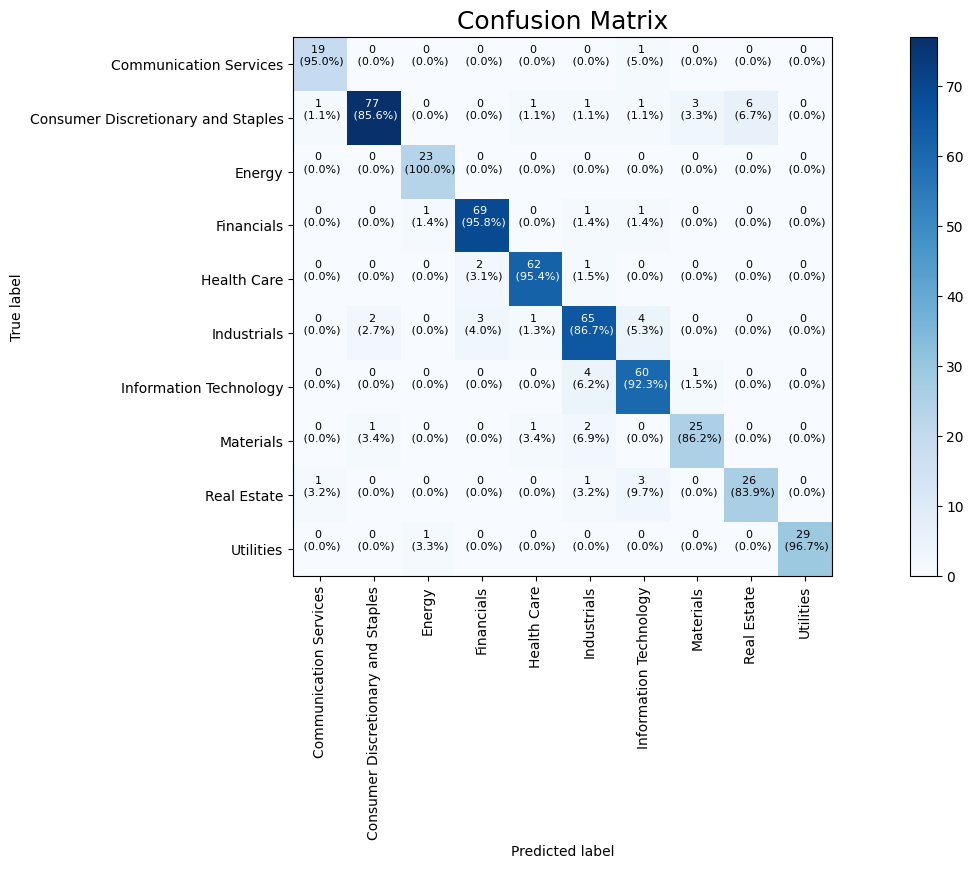

In [ ]:
# Generate a confusion matrix to show TESTING results by class
make_confusion_matrix(
    y_true=test_labels,
    y_pred=pred_output,
    classes=list(label_dict.keys()),
    figsize=(20, 7),
    text_size=8,
    norm=True,
    savefig=False,
)

# [5] Investigate Mis-classification

In [ ]:
# Display misclassified observations from the TESTING set
for i in np.where(test_labels != pred_output)[0]:
  true_label = list(
      filter(lambda x: label_dict[x] == test_labels[i], label_dict))[0]
  pred_label = list(
      filter(lambda x: label_dict[x] == pred_output[i], label_dict))[0]
  print(f'Truth: {test_labels[i]} - {true_label}')
  print(f'Predicted: {pred_output[i]} - {pred_label}')
  print(f'Text: {test_texts[i]}')
  print('-'*100)

Truth: 5 - Industrials
Predicted: 6 - Information Technology
Text: Business General Rockwell Automation Inc. Rockwell Automation or the Company is a global leader in industrial automation and digital transformation. We connect the imaginations of people with the potential of technology to expand what is humanly possible making the world more productive and more sustainable. The Company continues the business founded as the AllenBradley Company in . The Company was incorporated in Delaware in connection with a taxfree reorganization completed on December pursuant to which we divested our former aerospace and defense businesses the AD Business to The Boeing Company Boeing. Boeing then acquired RIC. Information included in this Annual Report on Form K refers to our continuing businesses unless otherwise indicated. The Intelligent Devices segment includes drives motion safety sensing industrial components and configuredtoorder products. Our operating segments share common sales supply chai

## [6] Save Predictions and Embeddings

In [ ]:
# Save Predictions to file
pred_df.to_csv('/content/gdrive/My Drive/project/data/embeddings/rbert_wt_predictions.csv', index=False)

In [ ]:
# Save Embeddings to file
pred_df.to_csv('/content/gdrive/My Drive/project/data/embeddings/rbert_wt_embeddings.csv', index=False)